## Physics Challenge

Welcome to the physics challenge of the MQST Qiskit Fall Fest!

In this challenge, you will study a spin system, a prototypical problem in condensed matter physics. Using VQE algorithm, you will find that spins can manifest different phases and behaviours even when they rest at their ground state.

#### Cell for installing necessary packages:

In [ ]:
 #Uncomment to install the necessary packages
 !pip install numpy
 !pip install scipy
 !pip install matplotlib
 !pip install jupyter
 !pip install qiskit[visualization]==1.2
 #For Local Linux or Mac, you can use the following command:
 !pip install 'qiskit[visualization]'==1.2
 !pip install qiskit_algorithms
 !pip install qiskit_aer
 !pip install qiskit_ibm_runtime
 !pip install qiskit_ibm_transpiler

## 1 - One ring to rule the spins

To simulate a quantum system, we need to determine the interactions between the quantum particles that constitute it by defining its Hamiltonian operator.
The system will be a ring that follows the XXZ Heisenberg model [[Ref.1]](#REF)<a class="anchor" id="Ref1"></a>, given by

$$ H_{XXZ} = -\frac{1}{4}\sum_{i=1}^N \sigma_i^x\sigma_{i+1}^x + \sigma_i^y\sigma_{i+1}^y + \Delta \, \sigma_i^z\sigma_{i+1}^z \,.$$

Here, $N$ is the number of spin-1/2 particles, $\Delta$ is the anisotropy parameter, and $\sigma^x_i$, $\sigma^y_i$, and $\sigma^z_i$ are Pauli operators, where the subscripts label the qubit they act on.
Furthermore, we impose the periodic boundary condition $\sigma^u_{i+N}=\sigma^u_{i}$ to make the object rest on a ring shape.
Note that only qubits next to each other interact, which means that we are restricting the interactions to first neighbours.

<p style="text-align: center"><img src="https://i.imgur.com/mw775Nx.png" width=400></p>

This model captures a rich range of behaviours throughout its phase diagram.
First off, for $\Delta=1$, the model converges to the isotropic Heisenberg Hamiltonian (XXX), where all the terms have the same coupling strength.
As we vary $\Delta$, the system can be in three phases:

- $\Delta> 1$: the **ferromagnetic** phase, where all spins point in the same direction.
- $-1<\Delta<1$: the **paramagnetic** or critical phase, where the spins are completely disordered.
- $\Delta<-1$: the **anti-ferromagnetic** phase, where neighboring spins are anti-aligned.

To start, **consider $N=12$ for all the calculations**.


Useful imports

In [ ]:
import numpy as np
import scipy
from qiskit_algorithms.optimizers import *
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.primitives import Estimator
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.minimum_eigensolvers import VQE
import matplotlib.pyplot as plt

## 1.1 - Ground state energy of the XXZ model

Quantum systems can be naturally found in their ground state (GS).
Thus, the first step is to learn to prepare GSs with the quantum computer.
A prominent approach to do so is through the **Variational Quantum Eigensolver (VQE)** algorithm [[Ref. 2]](#REF)<a class="anchor" id="Ref2"></a>.

Interestingly, the energy spectrum of the $H_{XXZ}$ model can be obtained analytically using the _Bethe ansatz_. For $\Delta>1$, the system is in the _ferromagnetic phase_, in which all the spins in the GS point towards the same direction. This GS energy $\epsilon_{GS}$ is known to be:

$$\epsilon_{GS}=-N\frac{\Delta}{4}\,.$$

### Prepare a simple $N$-qubit state to represent a GS wave function in the ferromagnetic phase. Compute its energy taking the expectation value of the Hamiltonian to confirm the theoretical result $\epsilon_{GS}$ for $\Delta=4$

> !!! Notice: The given empty functions are there to make your life and the organizers life easier, with a common frame, but if you think of another solutions go for it !!!

In [ ]:
import numpy as np

from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator


def nqubit_ferromagnetic_gs(nqubits: int) -> np.ndarray:
    """Returns the ground state of a n-qubit ferromagnetic Ising model.

    Args:
        nqubits (int): The number of qubits in the system.

    Returns:
        state (np.ndarray): The ground state of the system.
    """
    # Your code here
    # As it is the all same direction it is either the first or last basis state, and there are 2^N elements
    state = np.zeros(2**nqubits)
    state[0] = 1
    return state


def nqubit_ferromagnetic_gs_circuit(nqbits: int) -> QuantumCircuit:
    """Returns the energy of the ground state of a n-qubit ferromagnetic Ising model.

    Args:
        state_vector (np.ndarray): The state vector of the system.

    Returns:
        circuit (qiskit.QuantumCircuit): The circuit that prepares the state.
    """
    # Your code here
    circuit = QuantumCircuit(nqbits)
    return circuit


def nqubit_XXZ_hamiltonian(nqubits: int, delta: float) -> SparsePauliOp:
    """Returns the Hamiltonian of a n-qubit ferromagnetic Ising model.

    Args:
        nqubits (int): The number of qubits in the system.

    Returns:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
    """
    # Your code here
    labels = []  # variable where you store the operators
    coef = []  # variable where you store the coefficients

    for i in range(nqubits):  # operators
        # strings where the values are stored
        xstr = ""
        ystr = ""
        zstr = ""
        for j in range(nqubits):
            if i == j or j == (i + 1) % nqubits:
                xstr += "X"
                ystr += "Y"
                zstr += "Z"
            else:
                xstr += "I"
                ystr += "I"
                zstr += "I"
        labels.append(xstr)
        labels.append(ystr)
        labels.append(zstr)
        coef.append(-1 / 4)
        coef.append(-1 / 4)
        coef.append(-1 / 4 * delta)
    hamiltonian = SparsePauliOp(labels, coef)
    return hamiltonian


def compute_expected_value(circuit: QuantumCircuit, hamiltonian: SparsePauliOp) -> float:
    """Returns the expected value of the prepared state of the given circuit, and the passed operator.

    Args:
        circuit (qiskit.circuit.QuantumCircuit): The circuit that prepares the state.
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.

    Returns:
        energy_gs (float): The energy of the circuit state.
    """
    # Your code here
    from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

    estimator = Estimator(mode=AerSimulator())
    pub = (circuit, hamiltonian)
    job = estimator.run(pubs=[pub])
    energy_gs = job.result()[0].data.evs
    return energy_gs


Testing it works:
> (Take it as an example, edit it if your solution differs from the given one)

In [ ]:
# Parameters
nqubits = 12
delta = 4

# Computations
fm_gs_vector = nqubit_ferromagnetic_gs(nqubits)
fm_gs_circuit = nqubit_ferromagnetic_gs_circuit(nqubits)
fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
fm_gs_energy = compute_expected_value(fm_gs_circuit, fm_hamiltonian)

print(f"Expected energy: {-nqubits}, obtained energy: {fm_gs_energy}")

Expected energy: -12, obtained energy: -12.013671875


State preparation is not always that straightforward.
In the _anti-ferromagnetic phase_ (for $\Delta<-1$), the GS wave function is more difficult to prepare, as it consists of a non-trivial superposition of the computational basis states.

### Use an exact numerical solver to obtain the GS energy for $\Delta=-2$.
Hint, you may want to use sparse matrices to perform the exact diagonalization.

In [ ]:
import scipy


def obtain_first_hamiltonian_eigenvalue(hamiltonian: SparsePauliOp) -> tuple[np.ndarray, float]:
    """Returns the ground state of a n-qubit antiferromagnetic XXZ Heisenberg model.
        This function uses the exact diagonalization method to compute the ground state.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian to diagonalize.

    Returns:
        state (np.ndarray): The ground state of the system.
        energy_gs (float): The energy of the ground state.
    """
    # Your code here
    energy_gs, state = scipy.sparse.linalg.eigsh(hamiltonian.to_matrix(sparse=True), k=1, which="SR")

    return energy_gs, state

Testing the numerical diagonalization method:
> (Take it as an example, edit it if your solution differs from the given one)

In [ ]:
nqubits = 12
delta = -2

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
anti_fm_numerical_energy = obtain_first_hamiltonian_eigenvalue(anti_fm_hamiltonian)

print(f"Obtained energy: {anti_fm_numerical_energy[0]}")


Obtained energy: [-7.46011738]


Knowing the answer now, lets try and do the same as before, try to guess an initial guess circuit, for which we will check its expected value, and see if it coincides with the value we got from the exact diagonalization:

In [ ]:
def nqubit_anti_fm_initial_guess_circuit():
    """Returns the initial guessed circuit, for the ground state of the anti-ferromagnetic case.

    Returns:
        circuit (qiskit.QuantumCircuit): The circuit that prepares the state.
    """
    # Your code here
    circuit = QuantumCircuit(12)
    circuit.x(1)
    circuit.x(3)
    circuit.x(5)
    circuit.x(7)
    circuit.x(9)
    circuit.x(11)
    return circuit


Testing the initial guess circuit:
> (Take it as an example, edit it if your solution differs from the given one)

In [ ]:
nqubits = 12
delta = -2

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
anti_fm_initial_guess_circuit = nqubit_anti_fm_initial_guess_circuit()

anti_fm_initial_guess_energy = compute_expected_value(anti_fm_initial_guess_circuit, anti_fm_hamiltonian)

print(f"Minimum, numerical energy: {anti_fm_numerical_energy[0][0]}, Obtained energy: {anti_fm_initial_guess_energy}")

Minimum, numerical energy: -7.460117375510886, Obtained energy: -6.008056640625


Was it close? Yes, no? Can you think of a better solutions?

------

### Use the VQE algorithm to estimate the GS energy for $\Delta=-2$

In the VQE algorithm, we use a parameterized circuit to prepare the GS of our Hamiltonian.
We start with an initial guess of the circuit parameters and optimize them to minimize the expectation value of the Hamiltonian.
This naturally brings us (close) to the GS of the system, as it is, by definition, the state with the lowest energy.

Use the **VQE algorithm ([VQE](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VQE.html#qiskit_algorithms.VQE))** to prepare the GS of the Hamiltonian for the same value of $\Delta$.
You should try to achieve the closest estimate to the actual GS energy using an **ansatz consisting of three layers of single- and two-qubit gates (controlled-X), where two-qubit gates connect only near neighbor qubits**.
Furthermore, among the different possibilities for the optimizers that you can choose from, use the **Simultaneous Perturbation Stochastic Approximation ([SPSA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.SPSA.html#qiskit_algorithms.optimizers.SPSA)) optimizer**.

> Hint: [EfficientSU2](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.EfficientSU2) can help you to generate the ansatz circuit if you do not want to code every gate by hand.

####Definition of used functions

In [ ]:
def create_ansatz_vqe(n_qubits: int, ansatz_type: str, nlayers: int, entanglement_type: str) -> QuantumCircuit:
    """Returns the ansatz for the VQE algorithm.

    Args:
        n_qubits (int): The number of qubits in the system.
        ansatz_type (str): The type of two qubit gates used in the ansatz.
        nlayers (int): The number of layers in the ansatz.

        --You can use extra Args if you need it

    Returns:
        ansatz (qiskit.QuantumCircuit): The ansatz for the VQE algorithm.
    """

    # Your code goes here
    eff = EfficientSU2(
        n_qubits,
        su2_gates=["rz", "rx", "rz"],
        skip_final_rotation_layer=False,
        entanglement=entanglement_type,
        reps=nlayers,
    )  # alternativa con EfficientSU2
    # eff = TwoLocal(n_qubits, ['rz','rx','rz'], 'cx', skip_final_rotation_layer=True, entanglement='circular', reps=nlayers) #alternativa TwoLocal
    return eff


def intermediate_results(count, parameters, mean, std):
    # function used as a callable to make plots of convergence of the methods
    intermediate_energy.append(mean)


def nqubit_anti_fm_gs_energy_vqe(
    hamiltonian: SparsePauliOp,
    ansatz: QuantumCircuit,
    initial_params: np.ndarray,
    optimizer: Optimizer,
    n_iterations: int,
    callable_func,
    backend=AerSimulator(),
) -> float:
    """Returns the ground state of a n-qubit antiferromagnetic XXZ Heisenberg model.
        This function uses the VQE algorithm to compute the ground state.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
        ansatz (qiskit.QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (qiskit_algorithms.optimizers.Optimizer): The optimizer to use.
        backend (qiskit.providers.Backend): The backend to use.

        --You can use extra Args if you need it

    Returns:
        gs_energy (float): The ground state of the system.

    """
    estimator = Estimator()
    # Your code goes here
    #  gs_energy = _.minimize(...)  # Add your code
    #
    vqe = VQE(estimator, ansatz, optimizer, initial_point=initial_params, callback=callable_func)
    gs_energy = vqe.compute_minimum_eigenvalue(hamiltonian)

    # Hint: using `qiskit_algorithms`, your life will be much easier, specially in the next sections!
    # But you can use your own implementation, with your own `cost_function` and an imported optimizer if you want, check:
    # `basic_intro/notebooks_with_corrections/QFF_Graded_Notebook_2.ipynb`

    return gs_energy

####VQE test

<ipython-input-8-ae875925b921>:53: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


{   'aux_operators_evaluated': None,
    'cost_function_evals': 6000,
    'eigenvalue': -6.490074459571972,
    'optimal_circuit': <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x7f812b07d600>,
    'optimal_parameters': {   ParameterVectorElement(θ[13]): -0.048682067138153755,
                              ParameterVectorElement(θ[19]): 0.00933115058249188,
                              ParameterVectorElement(θ[11]): -0.14637436671178783,
                              ParameterVectorElement(θ[10]): 1.3518352736136372,
                              ParameterVectorElement(θ[14]): -1.0295914431820863,
                              ParameterVectorElement(θ[18]): -0.1313505023307588,
                              ParameterVectorElement(θ[20]): 0.02991604751560892,
                              ParameterVectorElement(θ[17]): 1.5423259842750616,
                              ParameterVectorElement(θ[16]): -1.8758754190699818,
                              ParameterVecto

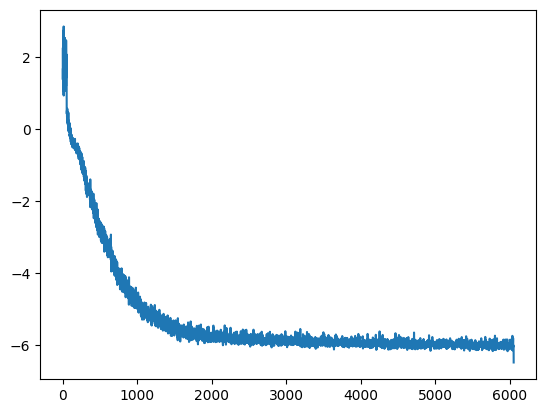

In [ ]:
nqubits = 12
delta = -2
nlayers = 3  # Choose the number of layers
niter = 3000  # number of iterations
optimizer = SPSA(niter)  # Choose the optimizer
entanglement_option = "circular"

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
ansatz_anti_fm = create_ansatz_vqe(nqubits, delta, nlayers, entanglement_option)

initial_params = np.zeros(ansatz_anti_fm.num_parameters)
# for i in range(12,ansatz_anti_fm.num_parameters,2):
#  initial_params[i] = -np.pi/2 Una mieda da -3.5

initial_params = (
    np.pi / 3 * np.random.random(ansatz_anti_fm.num_parameters) - np.pi / 6
)  # You might want to change this SLPQ -6.86 SLSQP -6.81 COBYLA -6.7 achieved -7.12
# for i in range (ansatz_anti_fm.num_parameters): #-6.6 COBYLA -6.7 SPSA shit SLQS
#  if (i//nqubits - 2)%3 and i%2 == 0:
#    initial_params[i] = np.pi
#  if (i//nqubits - 2)%3 == 1:
#    initial_params[i] = np.pi/2

intermediate_energy = []
x = []

anti_fm_vqe_energy = nqubit_anti_fm_gs_energy_vqe(
    anti_fm_hamiltonian, ansatz_anti_fm, initial_params, optimizer, niter, intermediate_results
)
print(anti_fm_vqe_energy)
for i in range(len(intermediate_energy)):
    x.append(i + 1)
plt.plot(x, intermediate_energy)

# print(f"Minimum, numerical energy: {anti_fm_numerical_energy[0]}, Obtained VQE energy: {anti_fm_vqe_energy}")


## 1.2 - Ansatz expressability

This method has several aspects that can be tuned, such as the shape of the ansatz or the optimization algorithm to find the parameters. These are important factors in more elaborate quantum simulations.
To better understand the role of these parameters, re-implement the method to solve the previous problem ($H_{XXZ}$ with $\Delta=-2$) and compare the results obtained with with different combinations of ansatz and classical optimizers.

 - **Ansatz**:

   - Choose the type of entanglement between ‘linear’, ‘pairwise’, ‘circular’.

 - **Optimizers**:

   - Simultaneous Perturbation Stochastic Approximation ([SPSA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.SPSA.html#qiskit_algorithms.optimizers.SPSA)) ;
   - Constrained Optimization By Linear Approximation ([COBYLA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.COBYLA.html#qiskit_algorithms.optimizers.COBYLA));
   - Sequential Least SQuares Programming ([SLSQP](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.SLSQP.html#qiskit_algorithms.optimizers.SLSQP)).

For all types of ansatz above, fix only 3 layers of each type of gate. Compare the 9 different combinations of ansatz and optimizer to understand which one performs better both in terms of the accuracy error obtained, and the time and number of steps to converge.

### Plot the estimate of the GS energy as a function of the optimization steps for all the combinations of optimizer and ansatz listed above. Discuss which combination is the best one for this specific problem.

> Hint: You might need to do several Python blocks (ant their Markdown titles), here. Maybe one for each combination of ansatz and optimizer (or not), and then another one to compare all of them with all the Plots is recommendable.

> Hint: take a look at predefined circuits like [TwoLocal](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal), and see how they work with the different entanglements and gate blocks.

###Definining the variables

---


For our created function of VQE optimization, we need the following parameters:



*   Hamiltonian (created with *nqubit_XXZ_hamiltonian*)
*   Ansatz (which can be created with a TwoLocal/EfficienSU2 circuit parametriser function)
* Initial parameters (an array)
* Optimizer (which will be different in every case)
* n_iterations (to do a fair comparison, use the same)
*callable_func (function to store intermediate values for the plots)














In [ ]:
num_qubits_12 = 12
delta_12 = -2
n_layers = 3
n_iterations = 8000  # Common parameter for all experiments
hamiltonian_12 = nqubit_XXZ_hamiltonian(num_qubits_12, delta_12)

###**SPSA**

In [ ]:
spsa = SPSA(n_iterations / 2)  # we devide by 2 as SPSA computes two values for each iteration (to better compare)

####Linear Entanglement

<ipython-input-9-bcfbbd346213>:51: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


{   'aux_operators_evaluated': None,
    'cost_function_evals': 8000,
    'eigenvalue': -6.709372992800375,
    'optimal_circuit': <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x7ee418ad4e20>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -0.5442061559541856,
                              ParameterVectorElement(θ[4]): 0.13879885608430642,
                              ParameterVectorElement(θ[1]): -1.4138939433605886,
                              ParameterVectorElement(θ[6]): -0.8151109027634943,
                              ParameterVectorElement(θ[9]): 1.3993934950301528,
                              ParameterVectorElement(θ[3]): -0.28168564698145043,
                              ParameterVectorElement(θ[2]): 0.1580137395401645,
                              ParameterVectorElement(θ[5]): -0.6532830818494216,
                              ParameterVectorElement(θ[11]): 0.27442309212824384,
                              ParameterVectorElement(θ

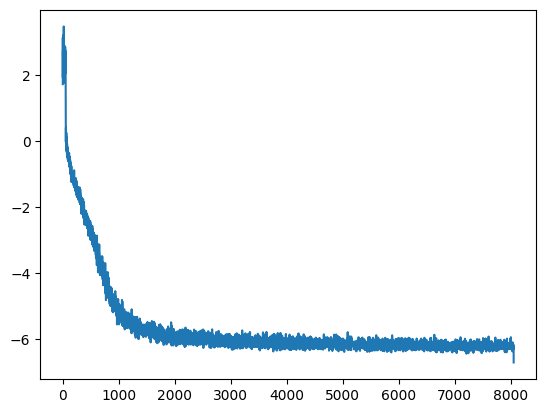

In [ ]:
entanglement_opt = "linear"

ansatz_spsa_lin = create_ansatz_vqe(nqubits, delta, n_layers, entanglement_opt)

initial_params = np.zeros(ansatz_spsa_lin.num_parameters)
initial_params = (
    np.pi / 3 * np.random.random(ansatz_spsa_lin.num_parameters) - np.pi / 6
)  # You might want to change this SLPQ -6.86 SLSQP -6.81 COBYLA -6.7


# for i in range(12,ansatz_spsa_12.num_parameters,2):
#  initial_params_spsa_lin[i] = -np.pi/2 Una mieda da -3.5
# for i in range (ansatz_spsa_12.num_parameters): #-6.6 COBYLA -6.7 SPSA shit SLQS
#  if (i//nqubits - 2)%3 and i%2 == 0:
#    initial_params_spsa_lin[i] = np.pi
#  if (i//nqubits - 2)%3 == 1:
#    initial_params_spsa_lin[i] = np.pi/2

initial_params_spsa_lin = initial_params

intermediate_energy_spsa_lin = []
x_spsa_lin = []


def intermediate_results_spsa_lin(count, parameters, mean, std):
    intermediate_energy_spsa_lin.append(mean)


anti_fm_vqe_spsa_lin = nqubit_anti_fm_gs_energy_vqe(
    hamiltonian_12, ansatz_spsa_lin, initial_params_spsa_lin, spsa, n_iterations / 2, intermediate_results_spsa_lin
)
print(anti_fm_vqe_spsa_lin)
for i in range(len(intermediate_energy_spsa_lin)):
    x_spsa_lin.append(i + 1)
plt.plot(x_spsa_lin, intermediate_energy_spsa_lin)
plt.title("SPSA linear entanglement")
plt.xlabel("Steps")
plt.ylabel("E")
plt.xscale("log")

####Circular Entanglement

<ipython-input-9-bcfbbd346213>:51: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


{   'aux_operators_evaluated': None,
    'cost_function_evals': 8000,
    'eigenvalue': -6.588661512429174,
    'optimal_circuit': <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x7ee420641cc0>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): 1.1641857119836625,
                              ParameterVectorElement(θ[4]): -1.6668418551899777,
                              ParameterVectorElement(θ[1]): -0.15787976341557544,
                              ParameterVectorElement(θ[6]): -1.7133514912322623,
                              ParameterVectorElement(θ[9]): 2.8600764946507793,
                              ParameterVectorElement(θ[3]): 2.944679248220236,
                              ParameterVectorElement(θ[2]): -0.02228454004894508,
                              ParameterVectorElement(θ[5]): 1.6813511768562597,
                              ParameterVectorElement(θ[11]): 2.057456774380128,
                              ParameterVectorElement(θ[14]

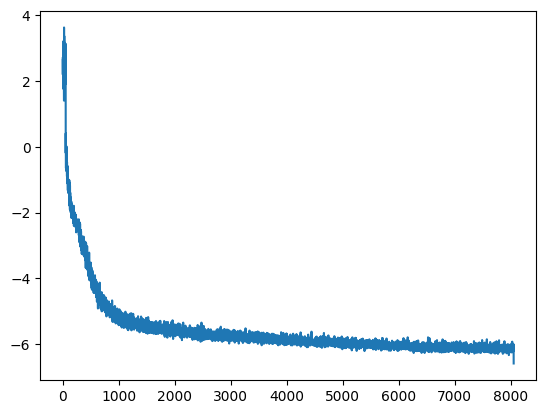

In [ ]:
entanglement_opt = "circular"


# for i in range(12,ansatz_spsa_12.num_parameters,2):
#  initial_params_spsa_cir[i] = -np.pi/2 Una mieda da -3.5
ansatz_spsa_cir = create_ansatz_vqe(nqubits, delta, nlayers, entanglement_opt)
# for i in range (ansatz_spsa_12.num_parameters): #-6.6 COBYLA -6.7 SPSA shit SLQS
#  if (i//nqubits - 2)%3 and i%2 == 0:
#    initial_params_spsa_cir[i] = np.pi
#  if (i//nqubits - 2)%3 == 1:
#    initial_params_spsa_cir[i] = np.pi/2

intermediate_energy_spsa_cir = []
x_spsa_cir = []


def intermediate_results_spsa_cir(count, parameters, mean, std):
    intermediate_energy_spsa_cir.append(mean)


anti_fm_vqe_spsa_cir = nqubit_anti_fm_gs_energy_vqe(
    hamiltonian_12, ansatz_spsa_lin, initial_params, spsa, n_iterations / 2, intermediate_results_spsa_cir
)
print(anti_fm_vqe_spsa_cir)
for i in range(len(intermediate_energy_spsa_cir)):
    x_spsa_cir.append(i + 1)
plt.plot(x_spsa_cir, intermediate_energy_spsa_cir)
plt.title("SPSA circular entanglement")
plt.xlabel("Steps")
plt.ylabel("E")
plt.xscale("log")

####Pairwise Entanglement

<ipython-input-9-bcfbbd346213>:51: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


{   'aux_operators_evaluated': None,
    'cost_function_evals': 8000,
    'eigenvalue': -6.8353750979499805,
    'optimal_circuit': <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x7ee40d96e200>,
    'optimal_parameters': {   ParameterVectorElement(θ[47]): -1.9872532315959475,
                              ParameterVectorElement(θ[134]): -0.5205106263237371,
                              ParameterVectorElement(θ[118]): 1.6431559430780642,
                              ParameterVectorElement(θ[121]): 0.25972270496064204,
                              ParameterVectorElement(θ[129]): 2.0179992963335454,
                              ParameterVectorElement(θ[141]): -0.30666324664131606,
                              ParameterVectorElement(θ[126]): 0.006077478671738958,
                              ParameterVectorElement(θ[133]): -0.08163756092640659,
                              ParameterVectorElement(θ[131]): -1.7755072726697292,
                              Param

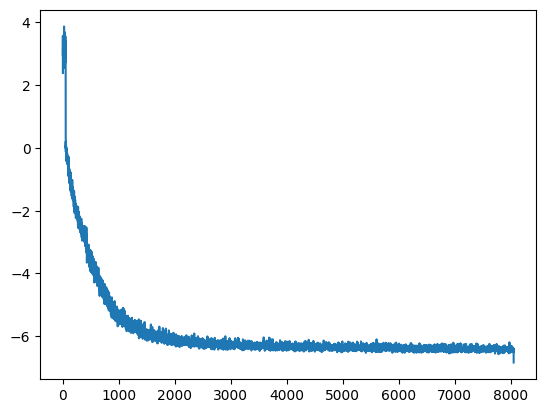

In [ ]:
entanglement_opt = "pairwise"

# initial_params_spsa_par = np.zeros(ansatz_spsa_12.num_parameters)
# for i in range(12,ansatz_spsa_12.num_parameters,2):
#  initial_params_spsa_par[i] = -np.pi/2 Una mieda da -3.5
ansatz_spsa_par = create_ansatz_vqe(nqubits, delta, nlayers, entanglement_opt)
initial_params_spsa_par = initial_params
# for i in range (ansatz_spsa_12.num_parameters): #-6.6 COBYLA -6.7 SPSA shit SLQS
#  if (i//nqubits - 2)%3 and i%2 == 0:
#    initial_params_spsa_par[i] = np.pi
#  if (i//nqubits - 2)%3 == 1:
#    initial_params_spsa_par[i] = np.pi/2

intermediate_energy_spsa_par = []
x_spsa_par = []


def intermediate_results_spsa_par(count, parameters, mean, std):
    intermediate_energy_spsa_par.append(mean)


anti_fm_vqe_spsa_par = nqubit_anti_fm_gs_energy_vqe(
    hamiltonian_12, ansatz_spsa_par, initial_params_spsa_par, spsa, n_iterations / 2, intermediate_results_spsa_par
)
print(anti_fm_vqe_spsa_par)
for i in range(len(intermediate_energy_spsa_par)):
    x_spsa_par.append(i + 1)
plt.plot(x_spsa_par, intermediate_energy_spsa_par)
plt.title("SPSA pairwise entanglement")
plt.xlabel("Steps")
plt.ylabel("E")
plt.xscale("log")

###**COBYLA**

In [ ]:
cobyla = COBYLA(n_iterations)

####Linear Entanglement

In [ ]:
entanglement_opt = "linear"


# initial_params_cobyla_lin = np.zeros(ansatz_cobyla_12.num_parameters)
# for i in range(12,ansatz_cobyla_12.num_parameters,2):
#  initial_params_cobyla_lin[i] = -np.pi/2 Una mieda da -3.5
ansatz_cobyla_lin = create_ansatz_vqe(nqubits, delta, nlayers, entanglement_opt)
# for i in range (ansatz_cobyla_12.num_parameters): #-6.6 COBYLA -6.7 SPSA shit SLQS
#  if (i//nqubits - 2)%3 and i%2 == 0:
#    initial_params_cobyla_lin[i] = np.pi
#  if (i//nqubits - 2)%3 == 1:
#    initial_params_cobyla_lin[i] = np.pi/2

intermediate_energy_cobyla_lin = []
x_cobyla_lin = []


def intermediate_results_cobyla_lin(count, parameters, mean, std):
    intermediate_energy_cobyla_lin.append(mean)


anti_fm_vqe_cobyla_lin = nqubit_anti_fm_gs_energy_vqe(
    hamiltonian_12, ansatz_cobyla_lin, initial_params, cobyla, n_iterations, intermediate_results_cobyla_lin
)
print(anti_fm_vqe_cobyla_lin)
for i in range(len(intermediate_energy_cobyla_lin)):
    x_cobyla_lin.append(i + 1)
plt.plot(x_cobyla_lin, intermediate_energy_cobyla_lin)
plt.title("COBYLA linear entanglement")
plt.xlabel("Steps")
plt.ylabel("E")
plt.xscale("log")

<ipython-input-8-bcfbbd346213>:51: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


KeyboardInterrupt: 

####Circular Entanglement

<ipython-input-9-bcfbbd346213>:51: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


{   'aux_operators_evaluated': None,
    'cost_function_evals': 8000,
    'eigenvalue': -7.058982537640255,
    'optimal_circuit': <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x7ee40d2e5d80>,
    'optimal_parameters': {   ParameterVectorElement(θ[31]): 1.215862223360524,
                              ParameterVectorElement(θ[32]): 1.3473071970451653,
                              ParameterVectorElement(θ[28]): 1.5766486878167263,
                              ParameterVectorElement(θ[30]): 1.711824460201067,
                              ParameterVectorElement(θ[1]): 0.9136256678682189,
                              ParameterVectorElement(θ[14]): 1.500122280393907,
                              ParameterVectorElement(θ[6]): -0.48982894938814453,
                              ParameterVectorElement(θ[11]): 0.13664528203056509,
                              ParameterVectorElement(θ[13]): 1.404463831833622,
                              ParameterVectorElement(θ[3]

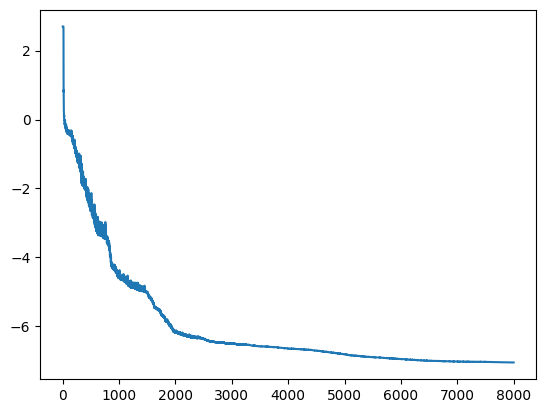

In [ ]:
entanglement_opt = "circular"

# initial_params_cobyla_lin = np.zeros(ansatz_cobyla_12.num_parameters)
# for i in range(12,ansatz_cobyla_12.num_parameters,2):
#  initial_params_cobyla_lin[i] = -np.pi/2 Una mieda da -3.5
ansatz_cobyla_cir = create_ansatz_vqe(nqubits, delta, 3, entanglement_opt)
# for i in range (ansatz_cobyla_12.num_parameters): #-6.6 COBYLA -6.7 SPSA shit SLQS
#  if (i//nqubits - 2)%3 and i%2 == 0:
#    initial_params_cobyla_lin[i] = np.pi
#  if (i//nqubits - 2)%3 == 1:
#    initial_params_cobyla_lin[i] = np.pi/2

intermediate_energy_cobyla_cir = []
x_cobyla_cir = []


def intermediate_results_cobyla_cir(count, parameters, mean, std):
    intermediate_energy_cobyla_cir.append(mean)


anti_fm_vqe_cobyla_cir = nqubit_anti_fm_gs_energy_vqe(
    hamiltonian_12, ansatz_cobyla_cir, initial_params, cobyla, n_iterations, intermediate_results_cobyla_cir
)
print(anti_fm_vqe_cobyla_cir)
for i in range(len(intermediate_energy_cobyla_cir)):
    x_cobyla_cir.append(i + 1)
plt.plot(x_cobyla_cir, intermediate_energy_cobyla_cir)
plt.title("COBYLA circular entanglement")
plt.xlabel("Steps")
plt.ylabel("E")
plt.xscale("log")

####Pairwise Entanglement

<ipython-input-9-bcfbbd346213>:51: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


{   'aux_operators_evaluated': None,
    'cost_function_evals': 8000,
    'eigenvalue': -6.397249873837738,
    'optimal_circuit': <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x7ee40cf1d630>,
    'optimal_parameters': {   ParameterVectorElement(θ[36]): 0.7473522921658092,
                              ParameterVectorElement(θ[28]): 1.566733157739722,
                              ParameterVectorElement(θ[21]): 1.403950121389305,
                              ParameterVectorElement(θ[41]): -0.0653073539305343,
                              ParameterVectorElement(θ[4]): 1.1739708077563815,
                              ParameterVectorElement(θ[19]): -0.24132302280267237,
                              ParameterVectorElement(θ[25]): 1.2516069487130734,
                              ParameterVectorElement(θ[37]): -0.5707804691878814,
                              ParameterVectorElement(θ[32]): 0.8315014823563465,
                              ParameterVectorElement(

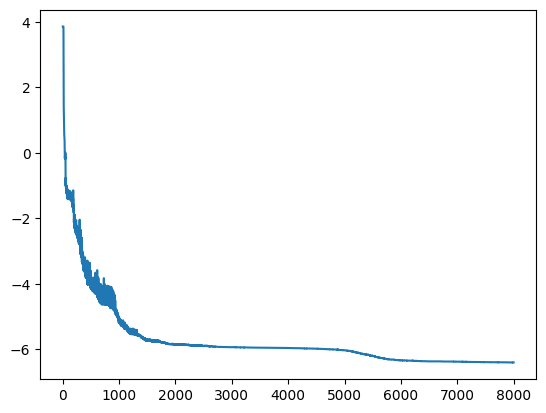

In [ ]:
entanglement_opt = "pairwise"

# initial_params_cobyla_lin = np.zeros(ansatz_cobyla_12.num_parameters)
# for i in range(12,ansatz_cobyla_12.num_parameters,2):
#  initial_params_cobyla_lin[i] = -np.pi/2 Una mieda da -3.5
ansatz_cobyla_par = create_ansatz_vqe(nqubits, delta, nlayers, entanglement_opt)
# for i in range (ansatz_cobyla_12.num_parameters): #-6.6 COBYLA -6.7 SPSA shit SLQS
#  if (i//nqubits - 2)%3 and i%2 == 0:
#    initial_params_cobyla_lin[i] = np.pi
#  if (i//nqubits - 2)%3 == 1:
#    initial_params_cobyla_lin[i] = np.pi/2

intermediate_energy_cobyla_par = []
x_cobyla_par = []


def intermediate_results_cobyla_par(count, parameters, mean, std):
    intermediate_energy_cobyla_par.append(mean)


anti_fm_vqe_cobyla_par = nqubit_anti_fm_gs_energy_vqe(
    hamiltonian_12, ansatz_cobyla_par, initial_params, cobyla, n_iterations, intermediate_results_cobyla_par
)
print(anti_fm_vqe_cobyla_par)
for i in range(len(intermediate_energy_cobyla_par)):
    x_cobyla_par.append(i + 1)
plt.plot(x_cobyla_par, intermediate_energy_cobyla_par)
plt.title("COBYLA pairwise entanglement")
plt.xlabel("Steps")
plt.ylabel("E")
plt.xscale("log")

###**SLSQP**

In [ ]:
slsqp = SLSQP(maxiter=n_iterations)

####Linear Entanglement

<ipython-input-9-bcfbbd346213>:51: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


{   'aux_operators_evaluated': None,
    'cost_function_evals': 17570,
    'eigenvalue': -6.870678064242871,
    'optimal_circuit': <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x7ee40cb1ffd0>,
    'optimal_parameters': {   ParameterVectorElement(θ[27]): -0.0022508960502223264,
                              ParameterVectorElement(θ[6]): 0.10578126502154754,
                              ParameterVectorElement(θ[3]): 0.13959827975233846,
                              ParameterVectorElement(θ[21]): 0.22904748996552848,
                              ParameterVectorElement(θ[8]): 0.42272000339756854,
                              ParameterVectorElement(θ[30]): 1.570968629115327,
                              ParameterVectorElement(θ[12]): -1.5708777765833069,
                              ParameterVectorElement(θ[14]): 1.5720936987198184,
                              ParameterVectorElement(θ[1]): 0.09102628768292978,
                              ParameterVectorEle

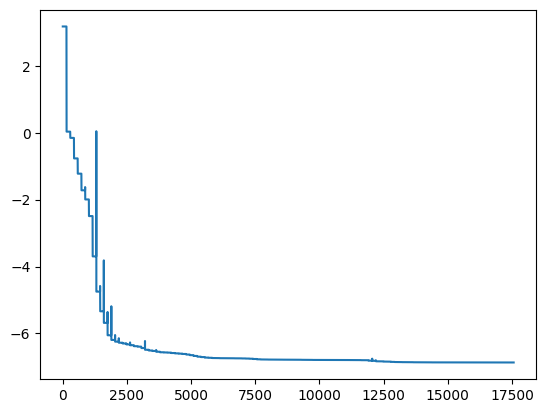

In [ ]:
entanglement_opt = "linear"

# initial_params_cobyla_lin = np.zeros(ansatz_cobyla_12.num_parameters)
# for i in range(12,ansatz_cobyla_12.num_parameters,2):
#  initial_params_cobyla_lin[i] = -np.pi/2 Una mieda da -3.5
ansatz_slsqp_lin = create_ansatz_vqe(nqubits, delta, nlayers, entanglement_opt)
# for i in range (ansatz_cobyla_12.num_parameters): #-6.6 COBYLA -6.7 SPSA shit SLQS
#  if (i//nqubits - 2)%3 and i%2 == 0:
#    initial_params_cobyla_lin[i] = np.pi
#  if (i//nqubits - 2)%3 == 1:
#    initial_params_cobyla_lin[i] = np.pi/2

intermediate_energy_slsqp_lin = []
x_slsqp_lin = []


def intermediate_results_slsqp_lin(count, parameters, mean, std):
    intermediate_energy_slsqp_lin.append(mean)


anti_fm_vqe_slsqp_lin = nqubit_anti_fm_gs_energy_vqe(
    hamiltonian_12, ansatz_slsqp_lin, initial_params, slsqp, n_iterations, intermediate_results_slsqp_lin
)
print(anti_fm_vqe_slsqp_lin)
for i in range(len(intermediate_energy_slsqp_lin)):
    x_slsqp_lin.append(i + 1)
plt.plot(x_slsqp_lin, intermediate_energy_slsqp_lin)
plt.title("SLSQP linear entanglement")
plt.xlabel("Steps")
plt.ylabel("E")
plt.xscale("log")

####Circular Entanglement

<ipython-input-9-bcfbbd346213>:51: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


{   'aux_operators_evaluated': None,
    'cost_function_evals': 17419,
    'eigenvalue': -6.980470080114739,
    'optimal_circuit': <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x7ee40c144340>,
    'optimal_parameters': {   ParameterVectorElement(θ[25]): -1.5707955894080246,
                              ParameterVectorElement(θ[11]): 0.11141456012957802,
                              ParameterVectorElement(θ[16]): 0.597355362094965,
                              ParameterVectorElement(θ[27]): 1.068050697272348,
                              ParameterVectorElement(θ[28]): 1.083366809408586,
                              ParameterVectorElement(θ[38]): -0.4320896915416735,
                              ParameterVectorElement(θ[19]): 0.0006635003663437333,
                              ParameterVectorElement(θ[17]): -1.5710289262315447,
                              ParameterVectorElement(θ[22]): -1.328081005446925,
                              ParameterVectorElem

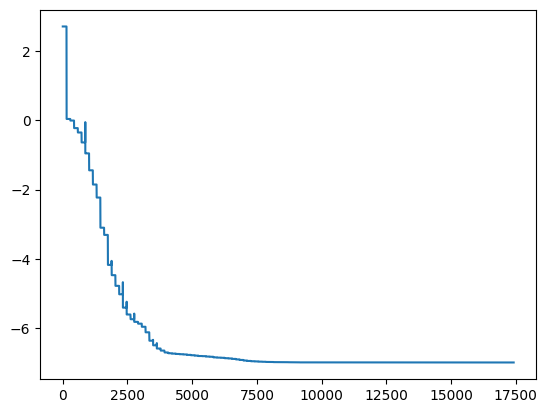

In [ ]:
entanglement_opt = "circular"

# initial_params_cobyla_lin = np.zeros(ansatz_cobyla_12.num_parameters)
# for i in range(12,ansatz_cobyla_12.num_parameters,2):
#  initial_params_cobyla_lin[i] = -np.pi/2 Una mieda da -3.5
ansatz_slsqp_cir = create_ansatz_vqe(nqubits, delta, nlayers, entanglement_opt)
# for i in range (ansatz_cobyla_12.num_parameters): #-6.6 COBYLA -6.7 SPSA shit SLQS
#  if (i//nqubits - 2)%3 and i%2 == 0:
#    initial_params_cobyla_lin[i] = np.pi
#  if (i//nqubits - 2)%3 == 1:
#    initial_params_cobyla_lin[i] = np.pi/2

intermediate_energy_slsqp_cir = []
x_slsqp_cir = []


def intermediate_results_slsqp_cir(count, parameters, mean, std):
    intermediate_energy_slsqp_cir.append(mean)


anti_fm_vqe_slsqp_cir = nqubit_anti_fm_gs_energy_vqe(
    hamiltonian_12, ansatz_slsqp_cir, initial_params, slsqp, n_iterations, intermediate_results_slsqp_cir
)
print(anti_fm_vqe_slsqp_cir)
for i in range(len(intermediate_energy_slsqp_cir)):
    x_slsqp_cir.append(i + 1)
plt.plot(x_slsqp_cir, intermediate_energy_slsqp_cir)
plt.title("SLSQP circular entanglement")
plt.xlabel("Steps")
plt.ylabel("E")
plt.xscale("log")

####Pairwise Entanglement

<ipython-input-9-bcfbbd346213>:51: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


{   'aux_operators_evaluated': None,
    'cost_function_evals': 24657,
    'eigenvalue': -6.921398452346391,
    'optimal_circuit': <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x7ee407996920>,
    'optimal_parameters': {   ParameterVectorElement(θ[110]): 0.9280066205071094,
                              ParameterVectorElement(θ[69]): 1.5892546612396181,
                              ParameterVectorElement(θ[131]): -3.141592653589793,
                              ParameterVectorElement(θ[127]): 1.5694586983734344,
                              ParameterVectorElement(θ[136]): 0.4592587404768113,
                              ParameterVectorElement(θ[120]): 0.00012818709261933599,
                              ParameterVectorElement(θ[118]): 0.12091915536247909,
                              ParameterVectorElement(θ[113]): -0.008670580425096778,
                              ParameterVectorElement(θ[102]): 1.5228969225417517,
                              Paramet

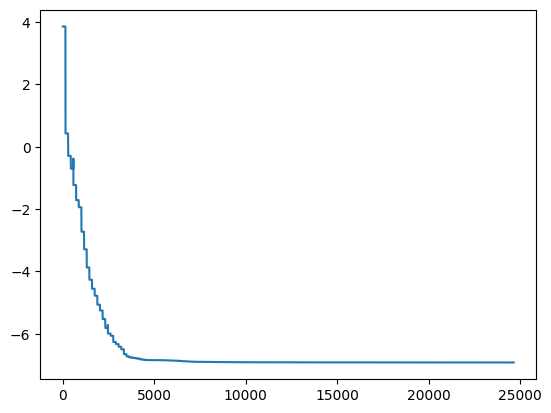

In [ ]:
entanglement_opt = "pairwise"

# initial_params_cobyla_lin = np.zeros(ansatz_cobyla_12.num_parameters)
# for i in range(12,ansatz_cobyla_12.num_parameters,2):
#  initial_params_cobyla_lin[i] = -np.pi/2 Una mieda da -3.5
ansatz_slsqp_par = create_ansatz_vqe(nqubits, delta, nlayers, entanglement_opt)
# for i in range (ansatz_cobyla_12.num_parameters): #-6.6 COBYLA -6.7 SPSA shit SLQS
#  if (i//nqubits - 2)%3 and i%2 == 0:
#    initial_params_cobyla_lin[i] = np.pi
#  if (i//nqubits - 2)%3 == 1:
#    initial_params_cobyla_lin[i] = np.pi/2

intermediate_energy_slsqp_par = []
x_slsqp_par = []


def intermediate_results_slsqp_par(count, parameters, mean, std):
    intermediate_energy_slsqp_par.append(mean)


anti_fm_vqe_slsqp_par = nqubit_anti_fm_gs_energy_vqe(
    hamiltonian_12, ansatz_slsqp_par, initial_params, slsqp, n_iterations, intermediate_results_slsqp_par
)
print(anti_fm_vqe_slsqp_par)
for i in range(len(intermediate_energy_slsqp_par)):
    x_slsqp_par.append(i + 1)
plt.plot(x_slsqp_par, intermediate_energy_slsqp_par)
plt.title("SLSQP pairwise entanglement")
plt.xlabel("Steps")
plt.ylabel("E")
plt.xscale("log")

###**Comparison**

We unfortunately rerun the plot cell without data and destroyed the figure, which took around one hour to generate, luckily we have a photo of it both in linear and logarithmic scale

Respect to the times, all the methods take more or less the same time per step, however the convergence behaviour is different:

  SLSQP shows the slowest convergence, but achieves results among the better. COBYLA and SPSA are faster, with COBYLA converging faster in the order between 10 and 10\^2  steps, but then converging at a similar rate to SPSA. Respect to the accuracy, SPSA, is the least precise of the 3, with COBYLA and SLSQP achieving similar results.

  At first thought, pairwise entangled ansatz should be the fastest to converge, as theses ansatz only have interactions between qubits by pairs, therefore, their hilbert subspace is smaller and faster to explore. The obtained eigenvalues will be less precise. (Nevertheless, note the good results of slsqp_par) However, as the physical system interacts in a circular pattern, these ansatz and linear will have more or less similar converge times, as in this case (N=12), the circular ansatz has only one extra CNOT. However, circular circuits seem to achieve better results. As the system uses Periodic Boundary Conditions, this seems the natural choice.


As a conclusion, we think that for short simulations COBYLA_LIN or a SPSA is the best option, whereas longer and more precise simulations should be performed using COBYLA_cir or a SLSQP method.


####Figure with linear scale

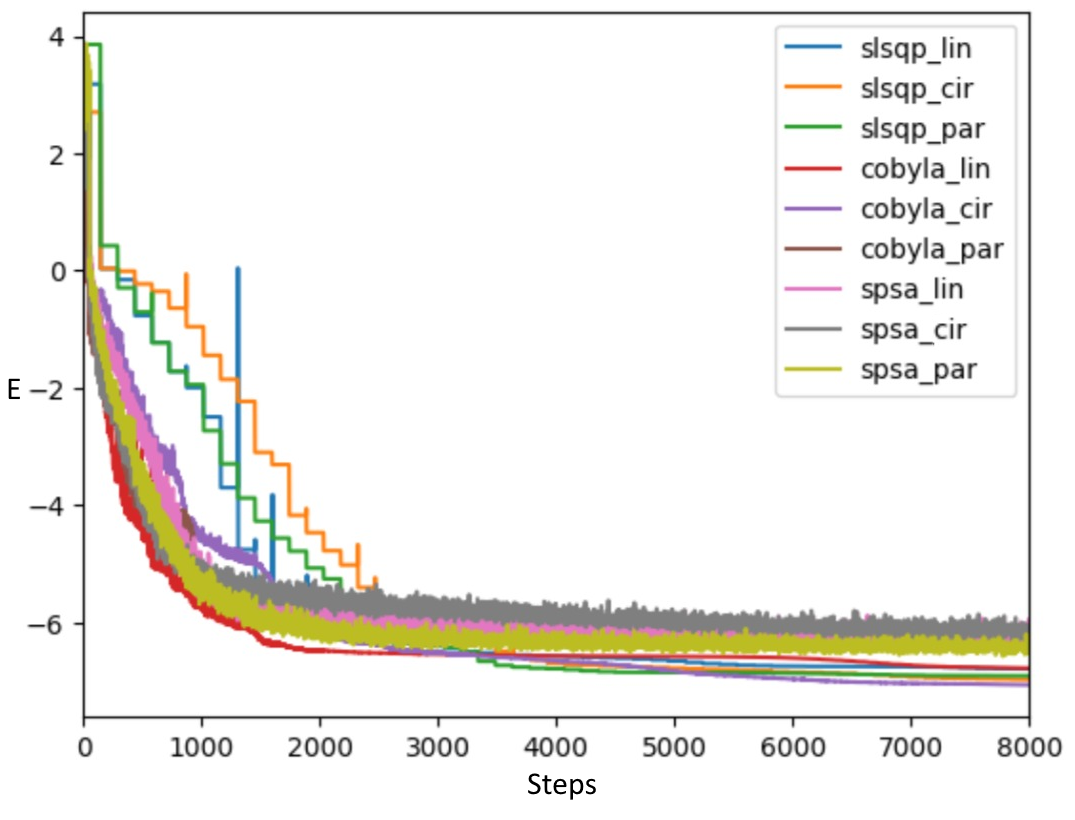

####Figure with log scale

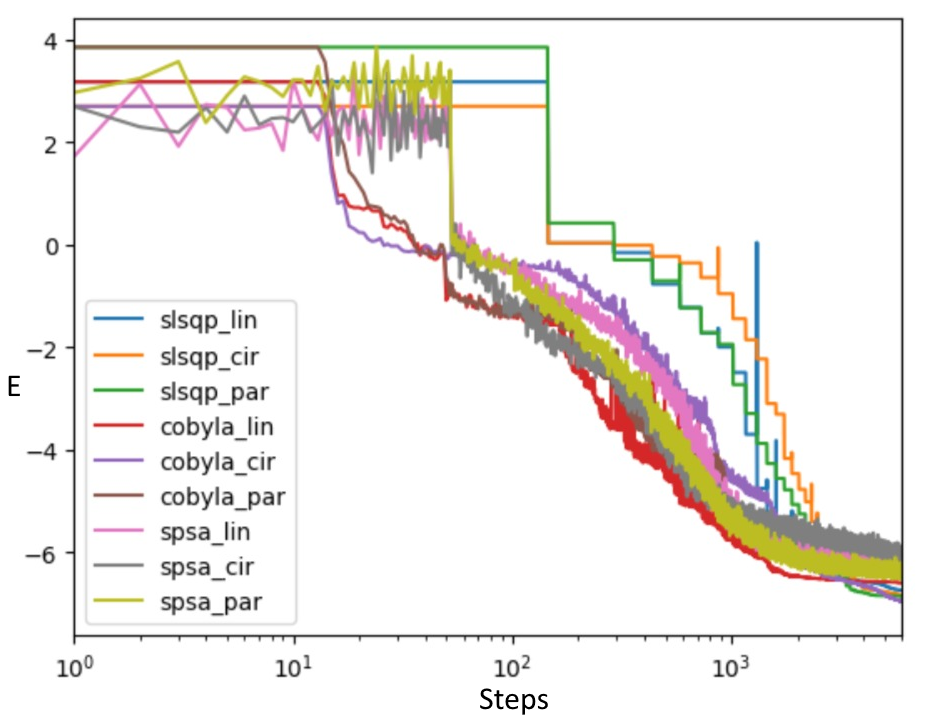

####Code to generate them

In [ ]:
plt.plot(x_slsqp_lin, intermediate_energy_slsqp_lin, label="slsqp_lin")
plt.plot(x_slsqp_cir, intermediate_energy_slsqp_cir, label="slsqp_cir")
plt.plot(x_slsqp_par, intermediate_energy_slsqp_par, label="slsqp_par")
plt.plot(x_cobyla_lin, intermediate_energy_cobyla_lin, label="cobyla_lin")
plt.plot(x_cobyla_cir, intermediate_energy_cobyla_cir, label="cobyla_cir")
plt.plot(x_cobyla_par, intermediate_energy_cobyla_par, label="cobyla_par")
plt.plot(x_spsa_lin, intermediate_energy_spsa_lin, label="spsa_lin")
plt.plot(x_spsa_cir, intermediate_energy_spsa_cir, label="spsa_cir")
plt.plot(x_spsa_par, intermediate_energy_spsa_par, label="spsa_par")
plt.legend()
plt.xlim(1, 8000)
plt.title("Convergence Comparison")
plt.xlabel("Steps")
plt.ylabel("E")
plt.xscale("log")

NameError: name 'x_slsqp_lin' is not defined

In [ ]:
# time comparision
print(f"SPSA lin: {anti_fm_vqe_spsa_lin.optimizer_time}")
print(f"SPSA cir: {anti_fm_vqe_spsa_cir.optimizer_time}")
print(f"spsa par: {anti_fm_vqe_spsa_par.optimizer_time}")
print(f"cobyla lin: {anti_fm_vqe_cobyla_lin.optimizer_time}")
print(f"cobyla cir:{anti_fm_vqe_cobyla_cir.optimizer_time}")
print(f"cobyla par: {anti_fm_vqe_cobyla_par.optimizer_time}")
print(f"slsqp lin: {anti_fm_vqe_slsqp_lin.optimizer_time/anti_fm_vqe_slsqp_lin.cost_function_evals*8000}")
print(f"slsqp cir: {anti_fm_vqe_slsqp_cir.optimizer_time/anti_fm_vqe_slsqp_cir.cost_function_evals*8000}")
print(f"slsqp par: {anti_fm_vqe_slsqp_par.optimizer_time/anti_fm_vqe_slsqp_par.cost_function_evals*8000}")

NameError: name 'anti_fm_vqe_spsa_lin' is not defined

In [ ]:
# step time comparision
print(f"SPSA lin: {anti_fm_vqe_spsa_lin.optimizer_time/8000}")
print(f"SPSA cir: {anti_fm_vqe_spsa_cir.optimizer_time/8000}")
print(f"spsa par: {anti_fm_vqe_spsa_par.optimizer_time/8000}")
print(f"cobyla lin: {anti_fm_vqe_cobyla_lin.optimizer_time/8000}")
print(f"cobyla cir:{anti_fm_vqe_cobyla_cir.optimizer_time/8000}")
print(f"cobyla par: {anti_fm_vqe_cobyla_par.optimizer_time/8000}")
print(f"slsqp lin: {anti_fm_vqe_slsqp_lin.optimizer_time/anti_fm_vqe_slsqp_lin.cos_function_evals}")
print(f"slsqp cir: {anti_fm_vqe_slsqp_cir.optimizer_time/anti_fm_vqe_slsqp_cir.cos_function_evals}")
print(f"slsqp par: {anti_fm_vqe_slsqp_par.optimizer_time/anti_fm_vqe_slsqp_par.cos_function_evals}")

NameError: name 'anti_fm_vqe_spsa_lin' is not defined

## 1.3 - Phase diagram

As we have introduced above, the full phase diagram of the $H_{XXZ}$ model encompasses a rich range of behaviours:

- For $\Delta>1$, we have a **ferromagnetic** phase.
- For $-1<\Delta<1$, we have a **paramagnetic** phase.
- For $\Delta\leq-1$, we have an **anti-ferromagnetic** phase.

Use the best combination of optimizer and ansatz that you have found before to prepare the GS of the system for different values of $\Delta$ to reconstruct the phase diagram.
Consider, at least, the values of $\Delta=\{-2, -1, 0, 1, 2\}$.
These will allow you to probe the properties of the GS in each phase.
If you can afford to use more points within the $\Delta\in[-2, 2]$ range, go for it!

Taking the exact solution (obtained by exact diagonalization or any other classical method that you might know) as a reference, try to improve the ansatz, e.g., adding more layers, to obtain a better representation of the GS of the system.

Once you find the optimal parameters for your best ansatz, use it to compute the expectation value of the **magnetization** of the system along the $z$-axis
$$
M \equiv \frac{1}{2N} \sum_{i=1}^{N} \left\langle \sigma_{i}^{z} \right\rangle\,,
$$
the **staggered magnetization**
$$
M_{st} \equiv \frac{1}{2N}\sum_{i=1}^N (-1)^i\left\langle\sigma_i^z\right\rangle\,,
$$
as well as the expectation value of the **nearest neighbour correlator**
$$
C \equiv \frac{1}{4N} \sum_{i=1}^{N}\left\langle \sigma_{i}^{z} \sigma_{i+1}^{z}  \right\rangle\,.
$$
Plot these observables as a function of $\Delta$.
You will need to prepare the GS multiple times to estimate these averages from the measurement statistics.

### Plot $M$, $M_{st}$ and $C$ as a function of $\Delta$ and comment on the GS properties you can infer from these observables.
> Tip: To avoid finding degenerate GSs, try to energetically favour one of those by adding an external magnetic field in one direction in the Hamiltonian $H_{XXZ} + \delta\sigma_0^z$ with small $\delta$. This will ease the computation of the previous observables.

---

We have done some test with the number of layers in the ansatz and we have decided that staying with 3 layers is the best option, as increasing the number leads to worst results, and less is too little to express precisely the ansatz



###Operator functions definitions

In [ ]:
def magnetization_operator_13(n_qubit_13: int):
    labels_mag_13 = []
    for i in range(n_qubit_13):  # operators
        # strings where the values are stored
        str_mag_13 = ""
        for j in range(n_qubit_13):
            if i == j:
                str_mag_13 += "Z"
            else:
                str_mag_13 += "I"
        labels_mag_13.append(str_mag_13)
    coef_mag_13 = []
    for i in range(n_qubit_13):
        coef_mag_13.append(1 / (2 * n_qubit_13))
    magn = SparsePauliOp(labels_mag_13, coef_mag_13)
    return magn

In [ ]:
def staggered_magnetization_operator_13(n_qubit_13: int):
    labels_stmag_13 = []
    for i in range(n_qubit_13):  # operators
        # strings where the values are stored
        str_stmag_13 = ""
        for j in range(n_qubit_13):
            if i == j:
                str_stmag_13 += "Z"
            else:
                str_stmag_13 += "I"
        labels_stmag_13.append(str_stmag_13)
    coef_stmag_13 = []
    for i in range(n_qubit_13):
        coef_stmag_13.append(((-1) ** i) * 1 / (2 * n_qubit_13))
    stmagn = SparsePauliOp(labels_stmag_13, coef_stmag_13)
    return stmagn

In [ ]:
def NN_correlator_operator_13(n_qubits_13: int) -> SparsePauliOp:
    # Your code here
    labels_nncorr_13 = []  # variable where you store the operators
    coef_nncorr_13 = []  # variable where you store the coefficients

    for i in range(n_qubits_13):  # operators
        # strings where the values are stored
        str_nncorr_13 = ""
        for j in range(n_qubits_13):
            if i == j or j == (i + 1) % n_qubits_13:
                str_nncorr_13 += "Z"
            else:
                str_nncorr_13 += "I"
        labels_nncorr_13.append(str_nncorr_13)
        coef_nncorr_13.append(1 / (4 * n_qubits_13))
    hamiltonian = SparsePauliOp(labels_nncorr_13, coef_nncorr_13)
    return hamiltonian

###Tools for the calculation

Paremeters and operators used for the calculation

In [ ]:
num_qubits_13 = 12
nlayers = 3

magnetization_13 = magnetization_operator_13(num_qubits_13)
staggered_magnetization_13 = staggered_magnetization_operator_13(num_qubits_13)
NN_corr_13 = NN_correlator_operator_13(num_qubits_13)

Useful functions

In [ ]:
def compute_magnetization(state_vector: QuantumCircuit) -> float:
    """Returns the magnetization of the system, given a state,

    Args:
        state_vector (np.ndarray): Desired state, to compute the magnetization from.

    Returns:
        magnetization (float): The average magnetization of the system, in the given state.
    """
    # Your code here
    magnetization = compute_expected_value(state_vector, magnetization_13)

    return magnetization


def compute_staggered_magnetization(state_vector: QuantumCircuit) -> float:
    """Returns the staggered magnetization of the system, given a state.

    Args:
        state_vector (np.ndarray): Desired state, to compute the staggered magnetization from.

    Returns:
        staggered_magnetization (float): The average magnetization of the system, in the given state.
    """
    # Your code here
    staggered_magnetization = compute_expected_value(state_vector, staggered_magnetization_13)
    return staggered_magnetization


def compute_nearest_neighbour_correlator(state_vector: QuantumCircuit) -> float:
    """Returns the nearest neighbour correlator of the system, given a state.

    Args:
        state_vector (np.ndarray): Desired state, to compute the nearest neighbour correlator from.

    Returns:
        nearest_neighbour_correlator (float): The average magnetization of the system, in the given state.
    """
    # Your code here
    nearest_neighbour_correlator = compute_expected_value(state_vector, NN_corr_13)

    return nearest_neighbour_correlator

####VQE algorithm, that returns the the state vector and not only the energy;

In [ ]:
def compute_gs_params_vqe(hamiltonian, ansatz, initial_params, optimizer) -> np.ndarray:
    """Returns the VQE optimal parameters of the circuit, to generate the ground state of the system.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
        ansatz (qiskit.QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (qiskit_algorithms.optimizers.Optimizer): The optimizer to use.

    Returns:
        gs_circuit_params (np.ndarray): The parameters of the circuit.
    """

    estimator = Estimator()

    vqe = VQE(estimator, ansatz, optimizer, initial_point=initial_params)
    gs_circuit_params = vqe.compute_minimum_eigenvalue(hamiltonian)

    return gs_circuit_params

Used hamiltonian

In [ ]:
def nqubit_XXZ_hamiltonian_13(delta, pequedel):
    # Pequedel es el parámetro que rompe la simetría
    # Your code here
    labels = []  # variable where you store the operators
    coef = []  # variable where you store the coefficients

    for i in range(nqubits):  # operators
        # strings where the values are stored
        xstr = ""
        ystr = ""
        zstr = ""
        for j in range(nqubits):
            if i == j or j == (i + 1) % nqubits:
                xstr += "X"
                ystr += "Y"
                zstr += "Z"
            else:
                xstr += "I"
                ystr += "I"
                zstr += "I"
        labels.append(xstr)
        labels.append(ystr)
        labels.append(zstr)
        coef.append(-1 / 4)
        coef.append(-1 / 4)
        coef.append(-1 / 4 * delta)
    xstr = ""
    for i in range(nqubits):
        if i == 0:
            xstr += "Z"
        else:
            xstr += "I"
    labels.append(xstr)
    coef.append(pequedel)
    hamiltonian = SparsePauliOp(labels, coef)
    return hamiltonian


###Calculation of the phase diagram
> We obtain the eigenvalues before

We use a different code for the ansatz

In [ ]:
# We use a different code for the ansatz
from qiskit.circuit.library import TwoLocal


# Function that creates the ansatz circuit
def create_ansatz_phasediag(num_qubits_ans, n_layers_an, ent_typ_ans):
    eff = TwoLocal(
        num_qubits_ans, ["rz", "rx", "rz"], "cz", ent_typ_ans, skip_final_rotation_layer=False, reps=n_layers_an
    )  # alternativa con EfficientSU2
    return eff

In [ ]:
optimal_ansatz = create_ansatz_phasediag(num_qubits_13, nlayers, "circular")  # Your code here
optimal_optimizer = COBYLA(6000)  # Your code here
optimal_initial_params = np.zeros(optimal_ansatz.num_parameters)
optimal_initial_params = (
    np.pi / 3 * np.random.random(optimal_ansatz.num_parameters) - np.pi / 6
)  # You might want to change this SLPQ -6.86 SLSQP -6.81 COBYLA -6.7
pequedel = -0.02

deltas = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]  # You might edit this list...
hamiltonians: list[SparsePauliOp] = [nqubit_XXZ_hamiltonian_13(delta=delta, pequedel=pequedel) for delta in deltas]

numerical_gs_energies = []

# Your code goes here
#
#

list_params_to_generate_gs = []


for hamiltonian in hamiltonians:
    vqe_optimal_parameters = nqubit_anti_fm_gs_energy_vqe(
        hamiltonian, optimal_ansatz, optimal_initial_params, optimal_optimizer, 2000, None
    )
    list_params_to_generate_gs.append(vqe_optimal_parameters)
    numerical_gs_energies.append(obtain_first_hamiltonian_eigenvalue(hamiltonian))

<ipython-input-8-ae875925b921>:53: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


KeyboardInterrupt: 

And compute the magnetizations, for the different ground states found:

In [ ]:
magnetizations = []
staggered_magnetizations = []
nearest_neighbour_correlators = []

for params_to_generate_gs in list_params_to_generate_gs:
    ground_state_circuit = params_to_generate_gs.optimal_circuit.decompose().assign_parameters(
        params_to_generate_gs.optimal_parameters
    )

    magnetizations.append(compute_magnetization(ground_state_circuit))
    staggered_magnetizations.append(compute_staggered_magnetization(ground_state_circuit))
    nearest_neighbour_correlators.append(compute_nearest_neighbour_correlator(ground_state_circuit))

Test of the states obtained: compare VQE-obtained energy vs numerical energy

In [ ]:
for i in range(len(numerical_gs_energies)):
    print(list_params_to_generate_gs[i].eigenvalue)
    print(numerical_gs_energies[i][0])

-7.120203241214523
[-7.46201881]
-5.804680186965919
[-6.35574982]
-4.557352449183384
[-5.38790798]
-4.024724273721825
[-4.55766188]
-3.48158502535772
[-3.86406121]
-3.1433745269456144
[-3.32309352]
-3.0196716954287584
[-3.02]
-4.519228050770466
[-4.52]
-6.01938954775139
[-6.02]


Finally Plot the `magnetization`, `staggered_magnetization` and `near-neighbour_correlations`, in function of $\Delta$,

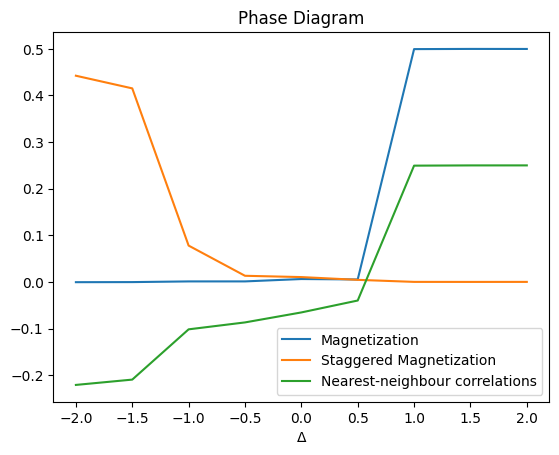

In [ ]:
import matplotlib.pyplot as plt

# Your styling goes here
#
#

plt.plot(deltas, magnetizations, label="Magnetization")
plt.plot(deltas, staggered_magnetizations, label="Staggered Magnetization")
plt.plot(deltas, nearest_neighbour_correlators, label="Nearest-neighbour correlations")

plt.xlabel("$\Delta$")
plt.title("Phase Diagram")
plt.legend()

The phase diagramme exhibits all the properties that we were expecting; the magnetization is different than 0 for Δ>0, which is the paramagnetic/ferromagnetic phase, where spins tend to be parallel. Whereas in Δ<0 is the staggered magnetization what is not negative, corresponding to antiparallel spins of the antiferromagnetic phase. The nearest-neighbour correlations show a similar behaviour to the expected ~tanh like.



## 1.4 - Excited states

Up to here we have just analyzed properties of the ground state of the system using VQE. Can we access excited eigenstates using a quantum circuit?

Check ([VQD](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VQD.html#qiskit_algorithms.VQD)) and use it to find the gap between the ground state and the excited state for $\delta=0.1$ and $\Delta=\{−2,−1,0,1,2\}$. How does the gap change as a function of $\Delta$?


We have coded this algorithm (composite) which does a VQE to aproximate to the ground state and then a VQD starting with the initial parameters of the VQE and then, and the normal one. However, the execution time was too long

In [ ]:
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_algorithms import VQD
from qiskit.primitives import Sampler


def compute_first_excited_energy_vqd_composite(hamiltonian, ansatz, initial_params, optimizer, callback) -> float:
    """Returns the VQD first excited state energy, of the system.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
        ansatz (qiskit.QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (qiskit_algorithms.optimizers.Optimizer): The optimizer to use.

    Returns:
        first_excited_energy (float): The first excited state energy.
    """

    # Your code here
    #
    #
    estimator = Estimator()
    vqe_14 = VQE(estimator, ansatz, optimizer, initial_point=initial_params, callback=None)
    print(vqe_14)
    previous_vqe = vqe_14.compute_minimum_eigenvalue(hamiltonian)
    initial_para_vqd = np.array(list(previous_vqe.optimal_parameters.values()))
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler)
    vqd = VQD(estimator, fidelity, ansatz, optimizer, k=2, initial_point=initial_para_vqd, callback=callback)
    vqdRes_14 = vqd.compute_eigenvalues(hamiltonian)

    # Hint: using `qiskit_algorithms`, your life will be much easier, specially in the next sections!
    # But you can use your own implementation, with your own `cost_function` and an imported optimizer if you want, check:
    # `basic_intro/notebooks_with_corrections/QFF_Graded_Notebook_2.ipynb`

    return vqdRes_14


def compute_first_excited_energy_vqd(hamiltonian, ansatz, initial_params, optimizer, callback) -> float:
    """Returns the VQD first excited state energy, of the system.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
        ansatz (qiskit.QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (qiskit_algorithms.optimizers.Optimizer): The optimizer to use.

    Returns:
        first_excited_energy (float): The first excited state energy.
    """

    # Your code here
    #
    #
    estimator = Estimator()
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler)
    vqd = VQD(estimator, fidelity, ansatz, optimizer, k=2, initial_point=initial_params, callback=callback)
    vqdRes_14 = vqd.compute_eigenvalues(hamiltonian)

    # Hint: using `qiskit_algorithms`, your life will be much easier, specially in the next sections!
    # But you can use your own implementation, with your own `cost_function` and an imported optimizer if you want, check:
    # `basic_intro/notebooks_with_corrections/QFF_Graded_Notebook_2.ipynb`
    return vqdRes_14


def compute_gap(vqd_result):
    """Returns the gap between the ground state and the excited state.

    Args:
        vqd_result (float): Energy of the first excited state, result of the VQD.

    Returns:
        gap (float): The gap between the ground state and the excited state.
    """
    gap = abs(vqd_result.eigenvalues.real[1] - vqd_result.eigenvalues.real[0])
    return gap

In [ ]:
intermediate_results_14 = []
intermediate_results_14_x = []


def callback_14(eval_count, params, value, meta, step):
    intermediate_results_14.append(value)
    intermediate_results_14_x.append(step)

Now call the functions and plot what ever you consider necessary:



In [ ]:
def obtain_numerical_bandgap(hamiltonian: SparsePauliOp) -> tuple[np.ndarray, float]:
    """Returns the ground state of a n-qubit antiferromagnetic XXZ Heisenberg model.
        This function uses the exact diagonalization method to compute the ground state.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian to diagonalize.

    Returns:
        state (np.ndarray): The ground state of the system.
        energy_gs (float): The energy of the ground state.
    """
    # Your code here
    aux = scipy.sparse.linalg.eigsh(hamiltonian.to_matrix(sparse=True), k=2, which="SR", return_eigenvectors=False)
    bandgap = aux[0] - aux[1]
    if bandgap < 0:
        bandgap = -bandgap
    return bandgap

This calculations are very fine, therefore using SPSA does not seem a good choice

In [ ]:
ansatz_14 = create_ansatz_phasediag(num_qubits_13, 5, "circular")
optimal_optimizer_14 = COBYLA(4000)  # Your code here
initial_params_14 = np.zeros(ansatz_14.num_parameters)
initial_params_14 = (
    np.pi / 3 * np.random.random(ansatz_14.num_parameters) - np.pi / 6
)  # You might want to change this SLPQ -6.86 SLSQP -6.81 COBYLA -6.7
pequedel_14 = 0.1

deltas_14 = [-2, -1, 0, 1, 2]  # You might edit this list...
hamiltonians_14: list[SparsePauliOp] = [
    nqubit_XXZ_hamiltonian_13(delta=delta, pequedel=pequedel_14) for delta in deltas_14
]

numerical_bandgaps_14 = []
vqd_bandgaps_14 = []
# Your code goes here
#
#


for hamiltonian in hamiltonians_14:
    # compute_first_excited_energy_vqd(hamiltonian, ansatz_14, initial_params, optimizer, callback_14)
    vqd_result_14 = compute_first_excited_energy_vqd(
        hamiltonian, ansatz_14, initial_params_14, optimal_optimizer_14, callback_14
    )
    vqd_bandgaps_14.append(compute_gap(vqd_result_14))
    numerical_bandgaps_14.append(obtain_numerical_bandgap(hamiltonian))

<ipython-input-20-74e19760897e>:53: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
<ipython-input-20-74e19760897e>:54: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


-5.058337403272073
-5.400058442094149
-3.757352232719425
-3.8725822551261118


<ipython-input-20-74e19760897e>:53: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
<ipython-input-20-74e19760897e>:54: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


-3.088290783257563
-3.099999999999931


<ipython-input-20-74e19760897e>:53: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
<ipython-input-20-74e19760897e>:54: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


-5.89999999999999
-6.100000000000005


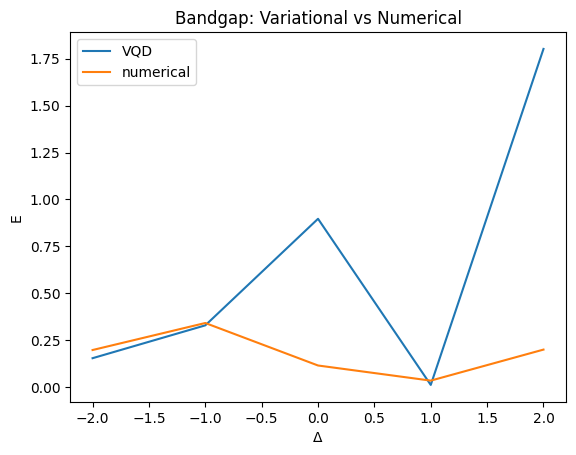

In [ ]:
plt.plot(deltas_14, vqd_bandgaps_14, label="VQD")
plt.plot(deltas_14, num_bandgaps_14, label="numerical")
plt.title("Bandgap: Variational vs Numerical")
plt.xlabel("$\Delta$")
plt.ylabel("E")
plt.legend()

The VQD result is really close to the numerical for 3 values, however, in two of them, the discrepance is surprinsingly big. We knew from the tests that the even the ground state calculation presents some discrepances, and we were expecting them, however the deviations are higher.

------
> ##### From now on, we won't limit you, so much, on the structure of the solution,
> ##### So be creative, but please, try to keep the solutions clean and [modular](https://medium.com/@tharinduBlog/python-functions-and-modular-programming-c2875d197a6)!
------

## 2 - The ring empire strikes back

Welcome to the second part of the challenge!
You have succeeded on solving a spin system using a quantum hybrid algorithm, so now we will bring the algorithm to its limits and tackle a very hard problem with it. Here you would show all your creativity and ability to improve the work done before.

The Kagome lattice consists of corner-sharing triangles and is characterized by a large degree of geometric frustration, which becomes visible for instance in an antiferromagnetic Heisenberg model: while two of the three spins can be antiparallel, the third one is frustrated—both possible configurations will always contain one good and bad bond and are hence degenerate. This results in a macroscopic degeneracy of configurations which can host new physics. This type of system is expected to form a spin liquid, where the spin distribution does not order even at zero temperature.

The following figure shows a Kagome unit cell of 12 spins, our new system:

<p style="text-align: center"><img src="https://i.imgur.com/67usdUW.png" width=600></p>

For a system like this ruled by the $H_{XXZ}$ hamiltonian, multiple phases can appear, some of them with predicted fractional excitations.

$$ H_{XXZ} = -\frac{1}{4}\sum_{<i, j>}^N \sigma_i^x\sigma_{j}^x + \sigma_i^y\sigma_{j}^y + \Delta \, \sigma_i^z\sigma_{j}^z \,.$$

where $<i,j>$ stands for nearest-neighbors pairs. This is of course a much more complex system that the one you have already studied, but now you have all the tools to face it with promising perspectives.

## 2.1- Repeat and refine

### Find the groundstate of the system for $\Delta = 1$ and compare it with the exact groundstate energy. How is the algorithm performing?



####Hamiltonian generation

In [ ]:
# function to generate the Kagome lattice hamiltonian
def hamiltonian_kagome_1(n_qubits_kag, delta):
    labels = []
    coef = []

    for i in range(0, n_qubits_kag, 2):
        xstr = ""
        ystr = ""
        zstr = ""
        for j in range(n_qubits_kag):
            if i == j or j == (i + 1) % n_qubits_kag:
                xstr += "X"
                ystr += "Y"
                zstr += "Z"
            else:
                xstr += "I"
                ystr += "I"
                zstr += "I"
        labels.append(xstr)
        labels.append(ystr)
        labels.append(zstr)
        coef.append(-1 / 4)
        coef.append(-1 / 4)
        coef.append(-1 / 4 * delta)
        xstr = ""
        ystr = ""
        zstr = ""
        for j in range(n_qubits_kag):
            if i == j or j == (i + 2) % n_qubits_kag:
                xstr += "X"
                ystr += "Y"
                zstr += "Z"
            else:
                xstr += "I"
                ystr += "I"
                zstr += "I"
        labels.append(xstr)
        labels.append(ystr)
        labels.append(zstr)
        coef.append(-1 / 4)
        coef.append(-1 / 4)
        coef.append(-1 / 4 * delta)
        xstr = ""
        ystr = ""
        zstr = ""
        for j in range(n_qubits_kag):
            if i == j or j == (i - 1) % n_qubits_kag:
                xstr += "X"
                ystr += "Y"
                zstr += "Z"
            else:
                xstr += "I"
                ystr += "I"
                zstr += "I"
        labels.append(xstr)
        labels.append(ystr)
        labels.append(zstr)
        coef.append(-1 / 4)
        coef.append(-1 / 4)
        coef.append(-1 / 4 * delta)

    hamiltonian = SparsePauliOp(labels, coef)
    return hamiltonian

####Numerical ground state calculation

In [ ]:
hamiltonian_kagome_21 = hamiltonian_kagome_1(12, 1)
energy_gs_num_kagome, state_gs_num_kagome = obtain_first_hamiltonian_eigenvalue(hamiltonian_kagome_21)
print(energy_gs_num_kagome)

[-4.5]


### Modify the ansatz length and/or shape and/or the optimizer to improve the ground state energy of the system.

In [ ]:
# Function that creates the ansatz circuit
def create_ansatz_kagome(num_qubits_ans, n_layers_an, ent_typ_ans):
    eff = TwoLocal(
        num_qubits_ans, ["rz", "rx", "rz"], "cz", ent_typ_ans, skip_final_rotation_layer=False, reps=n_layers_an
    )  # alternativa con EfficientSU2
    return eff

VQE algorithm (could reuse the old one, but just for easier organization)

In [ ]:
def nqubit_kagome_energy_vqe(
    hamiltonian: SparsePauliOp,
    ansatz: QuantumCircuit,
    initial_params: np.ndarray,
    optimizer: Optimizer,
    n_iterations: int,
    callable_func,
    backend=AerSimulator(),
) -> float:
    """Returns the ground state of a n-qubit antiferromagnetic XXZ Heisenberg model.
        This function uses the VQE algorithm to compute the ground state.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
        ansatz (qiskit.QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (qiskit_algorithms.optimizers.Optimizer): The optimizer to use.
        backend (qiskit.providers.Backend): The backend to use.

        --You can use extra Args if you need it

    Returns:
        gs_energy (float): The ground state of the system.

    """
    estimator = Estimator()
    vqe = VQE(estimator, ansatz, optimizer, initial_point=initial_params, callback=callable_func)
    gs_energy = vqe.compute_minimum_eigenvalue(hamiltonian)

    # Hint: using `qiskit_algorithms`, your life will be much easier, specially in the next sections!
    # But you can use your own implementation, with your own `cost_function` and an imported optimizer if you want, check:
    # `basic_intro/notebooks_with_corrections/QFF_Graded_Notebook_2.ipynb`

    return gs_energy

In [ ]:
# callable function used to plot the convergence of the VQE just to know
def callable_21(count, parameters, mean, std):
    intermediate_results_21.append(mean)
    intermediate_results_21_x.append(count)

Cálculo de la energía del estado fundamental

In [ ]:
n_layer_21 = 4
num_qubits_21 = 12
ansatz_21 = create_ansatz_kagome(num_qubits_21, n_layer_21, "linear")
initial_params_21 = np.zeros(ansatz_21.num_parameters)
initial_params_21 = (
    np.pi / 3 * np.random.random(ansatz_21.num_parameters) - np.pi / 6
)  # You might want to change this SLPQ -6.86 SLSQP -6.81 COBYLA -6.7 achieved -7.12

intermediate_results_21 = []
intermediate_results_21_x = []

n_iter_21 = 3000
optimizer_21 = COBYLA(n_iter_21)

kagome_energy_gs_delta1 = nqubit_kagome_energy_vqe(
    hamiltonian_kagome_21, ansatz_21, initial_params_21, optimizer_21, n_iter_21, callable_21
)

<ipython-input-124-147d725f93da>:20: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [ ]:
print("Numerical ground state energy: ", end="")
print(energy_gs_num_kagome)
print("VQE ground state energy: ", end="")
print(kagome_energy_gs_delta1.eigenvalue)

Numerical ground state energy: [-4.5]
VQE ground state energy: -4.493179055986503


We decided to use the COBYLA linear method as we wanted a fast good result, actually, the obtained result is almost perfect

## 2.2- Exploring the phases of this system

Now that you have mastered the convergence of this system, let's give everything to explore new physics (if they appear).

### Find the ground state of this system for $\Delta=\{-2,-1,0,1,2\}$ using the VQE algorithm and compute also $M$, $M_{st}$ and $C$ as a function of $\Delta$ and describe the phases that appear. Can you find any other observable that describes any new phase?

As spin liquids fluctuate we will obtain the variance of the S\_z spin

###Code to test

After some trial and error, an ansatz of 5 layers entangled with a CZ seemed to get the best results

In [ ]:
# Function that creates the ansatz circuit
def create_ansatz_kagome_22(num_qubits_ans, n_layers_an, ent_typ_ans):
    eff = TwoLocal(
        num_qubits_ans, ["rz", "rx", "rz"], "cz", ent_typ_ans, skip_final_rotation_layer=False, reps=n_layers_an
    )  # alternativa con EfficientSU2
    return eff

In [ ]:
hamiltonian_kagome_2deltamenos2 = hamiltonian_kagome_1(12, -2)
energy_gs_num_kagomedeltamenos2, state_gs_num_kagomedeltamenos2 = obtain_first_hamiltonian_eigenvalue(
    hamiltonian_kagome_2deltamenos2
)
print(energy_gs_num_kagomedeltamenos2)

# Your code here
n_layer_22 = 5
num_qubits_22 = 12
ansatz_22 = create_ansatz_kagome_22(num_qubits_22, n_layer_22, "circular")
initial_params_22 = np.zeros(ansatz_22.num_parameters)
initial_params_22 = (
    np.pi / 3 * np.random.random(ansatz_22.num_parameters) - np.pi / 6
)  # You might want to change this SLPQ -6.86 SLSQP -6.81 COBYLA -6.7 achieved -7.12

intermediate_results_22 = []
intermediate_results_22_x = []

n_iter_22 = 4000
optimizer_22 = COBYLA(n_iter_22)

kagome_energy_gs_deltamenos2 = nqubit_kagome_energy_vqe(
    hamiltonian_kagome_2deltamenos2, ansatz_22, initial_params_22, optimizer_22, n_iter_22, callable_22
)

[-7.76175574]


In [ ]:
# callable function used to plot the convergence of the VQE just to know
def callable_22(count, parameters, mean, std):
    intermediate_results_22.append(mean)
    intermediate_results_22_x.append(count)

Text(0, 0.5, 'Energy')

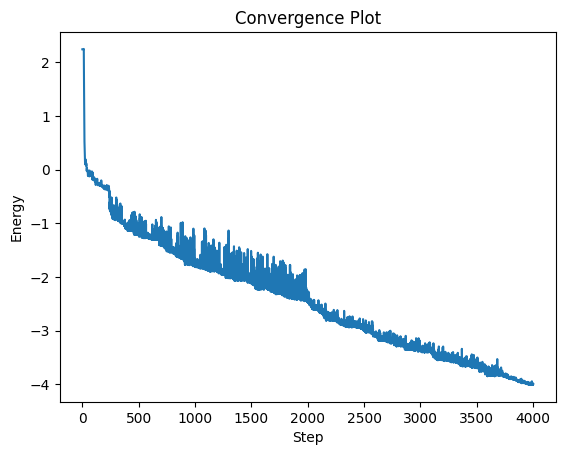

In [ ]:
import matplotlib.pyplot as plt

plt.plot(intermediate_results_22_x, intermediate_results_22)
plt.title("Convergence Plot")
plt.xlabel("Step")
plt.ylabel("Energy")

###Definition of the operators

We could reuse all except the correlation of nearest neighbours

In [ ]:
def magnetization_operator_22(n_qubit_22: int):
    labels_mag_22 = []
    for i in range(n_qubit_22):  # operators
        # strings where the values are stored
        str_mag_22 = ""
        for j in range(n_qubit_22):
            if i == j:
                str_mag_22 += "Z"
            else:
                str_mag_22 += "I"
        labels_mag_22.append(str_mag_22)
    coef_mag_22 = []
    for i in range(n_qubit_22):
        coef_mag_22.append(1 / (2 * n_qubit_22))
    magn = SparsePauliOp(labels_mag_22, coef_mag_22)
    return magn

In [ ]:
def staggered_magnetization_operator_22(n_qubit_22: int):
    labels_stmag_22 = []
    for i in range(n_qubit_22):  # operators
        # strings where the values are stored
        str_stmag_22 = ""
        for j in range(n_qubit_22):
            if i == j:
                str_stmag_22 += "Z"
            else:
                str_stmag_22 += "I"
        labels_stmag_22.append(str_stmag_22)
    coef_stmag_22 = []
    for i in range(n_qubit_22):
        coef_stmag_22.append(((-1) ** i) * 1 / (2 * n_qubit_22))
    stmagn = SparsePauliOp(labels_stmag_22, coef_stmag_22)
    return stmagn

In [ ]:
def NN_correlator_operator_22(n_qubits_22: int) -> SparsePauliOp:
    # Your code here
    labels_nncorr_22 = []  # variable where you store the operators
    coef_nncorr_22 = []  # variable where you store the coefficients

    for i in range(n_qubits_22):  # operators
        # strings where the values are stored

        str_nncorr_22 = ""
        for i in range(0, n_qubits_22, 2):
            str_nncorr22 = ""
            for j in range(n_qubits_22):
                if i == j or j == (i + 1) % n_qubits_22:
                    str_nncorr22 += "Z"
                else:
                    str_nncorr22 += "I"
            labels_nncorr_22.append(str_nncorr22)
            coef_nncorr_22.append(1 / (4 * n_qubits_22))

            str_nncorr22 = ""
            for j in range(n_qubits_22):
                if i == j or j == (i - 1) % n_qubits_22:
                    str_nncorr22 += "Z"
                else:
                    str_nncorr22 += "I"
            labels_nncorr_22.append(str_nncorr22)
            coef_nncorr_22.append(1 / (4 * n_qubits_22))

            str_nncorr22 = ""
            for j in range(n_qubits_22):
                if i == j or j == (i + 2) % n_qubits_22:
                    str_nncorr22 += "Z"
                else:
                    str_nncorr22 += "I"
            labels_nncorr_22.append(str_nncorr22)
            coef_nncorr_22.append(1 / (4 * n_qubits_22))

        hamiltonian = SparsePauliOp(labels_nncorr_22, coef_nncorr_22)
        return hamiltonian

###Operators to compute the observable

In [ ]:
def compute_magnetization_22(state_vector: QuantumCircuit) -> float:
    # Your code here
    magnetization22 = compute_expected_value(state_vector, magnetization_op_22)

    return magnetization22


def compute_staggered_magnetization_22(state_vector: QuantumCircuit) -> float:
    # Your code here
    staggered_magnetization22 = compute_expected_value(state_vector, staggered_magnetization_op_22)

    return staggered_magnetization22


def compute_nearest_neighbour_correlator_22(state_vector: QuantumCircuit) -> float:
    """Returns the nearest neighbour correlator of the system, given a state.

    Args:
        state_vector (np.ndarray): Desired state, to compute the nearest neighbour correlator from.

    Returns:
        nearest_neighbour_correlator (float): The average magnetization of the system, in the given state.
    """
    # Your code here
    nearest_neighbour_correlator_22 = compute_expected_value(state_vector, NN_op_corr_22)
    return nearest_neighbour_correlator_22


def compute_variance_Sz_22(state_vector):
    Z_par = SparsePauliOp("ZIIIIIIIIIII")
    Z_impar = SparsePauliOp("IZIIIIIIIIII")

    # as the pauliZ^2=I, the expected value of it will be 1
    var_par = 1 - compute_expected_value(state_vector, Z_par)
    var_impar = 1 - compute_expected_value(state_vector, Z_impar)
    return var_par, var_impar

###Calculation

#### Hamiltonian function generator (Remember that the hamiltonian needs to have a small perturbation in z)

In [ ]:
# function to generate the Kagome lattice hamiltonian
def hamiltonian_kagome_22(n_qubits_kag, delta, pequedelta):
    labels = []
    coef = []

    for i in range(0, n_qubits_kag, 2):
        xstr = ""
        ystr = ""
        zstr = ""
        for j in range(n_qubits_kag):
            if i == j or j == (i + 1) % n_qubits_kag:
                xstr += "X"
                ystr += "Y"
                zstr += "Z"
            else:
                xstr += "I"
                ystr += "I"
                zstr += "I"
        labels.append(xstr)
        labels.append(ystr)
        labels.append(zstr)
        coef.append(-1 / 4)
        coef.append(-1 / 4)
        coef.append(-1 / 4 * delta)
        xstr = ""
        ystr = ""
        zstr = ""
        for j in range(n_qubits_kag):
            if i == j or j == (i + 2) % n_qubits_kag:
                xstr += "X"
                ystr += "Y"
                zstr += "Z"
            else:
                xstr += "I"
                ystr += "I"
                zstr += "I"
        labels.append(xstr)
        labels.append(ystr)
        labels.append(zstr)
        coef.append(-1 / 4)
        coef.append(-1 / 4)
        coef.append(-1 / 4 * delta)
        xstr = ""
        ystr = ""
        zstr = ""
        for j in range(n_qubits_kag):
            if i == j or j == (i - 1) % n_qubits_kag:
                xstr += "X"
                ystr += "Y"
                zstr += "Z"
            else:
                xstr += "I"
                ystr += "I"
                zstr += "I"
        labels.append(xstr)
        labels.append(ystr)
        labels.append(zstr)
        coef.append(-1 / 4)
        coef.append(-1 / 4)
        coef.append(-1 / 4 * delta)
        zstr = ""
        for i in range(n_qubits_kag):
            if i == 0:
                zstr += "Z"
            else:
                zstr += "I"
        labels.append(zstr)
        coef.append(pequedelta)
    hamiltonian = SparsePauliOp(labels, coef)
    return hamiltonian

####Code of the phase diagram


In [ ]:
optimal_ansatz_22 = create_ansatz_kagome_22(12, 5, "circular")
optimal_optimizer_22 = COBYLA(4000)  # Your code here
optimal_initial_params_22 = np.zeros(optimal_ansatz_22.num_parameters)
optimal_initial_params_22 = (
    np.pi / 3 * np.random.random(optimal_ansatz_22.num_parameters) - np.pi / 6
)  # You might want to change this SLPQ -6.86 SLSQP -6.81 COBYLA -6.7
pequedel_22 = -0.02

deltas_22 = [-2, -1, 0, 1, 2]  # You might edit this list...
hamiltonians_22: list[SparsePauliOp] = [
    hamiltonian_kagome_22(12, delta=delta_22, pequedelta=pequedel_22) for delta_22 in deltas_22
]

# Your code goes here
#
#

numerical_gs_energies_22 = []
list_params_to_generate_gs_22 = []


for hamiltonian_22 in hamiltonians_22:
    vqe_optimal_parameters_22 = nqubit_anti_fm_gs_energy_vqe(
        hamiltonian_22, optimal_ansatz_22, optimal_initial_params_22, optimal_optimizer_22, 2000, None
    )
    list_params_to_generate_gs_22.append(vqe_optimal_parameters_22)
    numerical_gs_energies_22.append(obtain_first_hamiltonian_eigenvalue(hamiltonian_22))

<ipython-input-8-ae875925b921>:53: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
<ipython-input-8-ae875925b921>:53: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [ ]:
staggered_magnetization_op_22 = staggered_magnetization_operator_22(12)
magnetization_op_22 = magnetization_operator_22(12)
NN_op_corr_22 = NN_correlator_operator_22(12)

magnetizations_22 = []
staggered_magnetizations_22 = []
nearest_neighbour_correlators_22 = []
variance_Sz_par = []
variance_Sz_impar = []
for params_to_generate_gs_22 in list_params_to_generate_gs_22:
    ground_state_circuit = params_to_generate_gs_22.optimal_circuit.decompose().assign_parameters(
        params_to_generate_gs_22.optimal_parameters
    )
    magnetizations_22.append(compute_magnetization_22(ground_state_circuit))
    staggered_magnetizations_22.append(compute_staggered_magnetization_22(ground_state_circuit))
    compute_nearest_neighbour_correlator_22(ground_state_circuit)
    nearest_neighbour_correlators_22.append(compute_nearest_neighbour_correlator_22(ground_state_circuit))
    aux1, aux2 = compute_variance_Sz_22(ground_state_circuit)
    variance_Sz_par.append(aux1)
    variance_Sz_impar.append(aux2)

In [ ]:
print(variance_Sz_par)
print(variance_Sz_impar)

[0.9619140625, 0.8505859375, 0.861328125, 0.00390625, 0.001953125]
[0.86865234375, 1.04345703125, 0.97900390625, 0.00927734375, 0.00048828125]


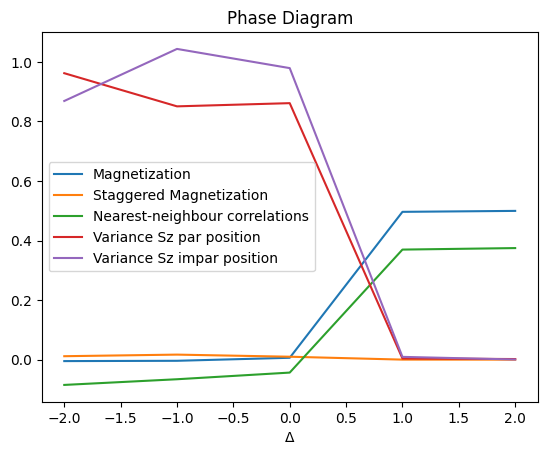

In [ ]:
plt.plot(deltas_22, magnetizations_22, label="Magnetization")
plt.plot(deltas_22, staggered_magnetizations_22, label="Staggered Magnetization")
plt.plot(deltas_22, nearest_neighbour_correlators_22, label="Nearest-neighbour correlations")
plt.plot(deltas_22, variance_Sz_par, label="Variance Sz par position")
plt.plot(deltas_22, variance_Sz_impar, label="Variance Sz impar position")

plt.xlabel("$\Delta$")
plt.title("Phase Diagram")
plt.legend()

The phase diagram shows a ferromagnetic phase in Δ > 1, however the phase in Δ < -1 shows no staggered magnetization nor magnetization. This is probably due to states of superpositions, consequence of the magnetic frustration.

Energy comparison

In [ ]:
for i in range(5):
    print(numerical_gs_energies_22[i][0])
for i in list_params_to_generate_gs_22:
    print(i.eigenvalue)

[-7.76934102]
[-6.46562878]
[-5.30863256]
[-4.62]
[-9.12]
-6.685495193957581
-5.602850344335161
-4.832331617684244
-4.614630047856775
-9.10898772080028


## 2.3 - Imperfect devices

In the current noisy intermediate-scale quantum (NISQ) devices, the operations are imperfect and the errors accumulate along the execution of the circuit.
In particular, two-qubit operations, such as the CNOT, have the highest errors.

### Find the GS and the first excited state of the Kagome System using a real quantum device ([run-jobs](https://docs.quantum.ibm.com/guides/run-jobs-session)) (you will need an IBM account for that), or at least a simulator of a noisy device that can be run locally ([local-testing-mode](https://docs.quantum.ibm.com/guides/local-testing-mode)).

Is there anything you can change to improve the result?
- Increase transpilation optimization
- Adapt the ansatz to the hardware, reduce error source.
- Include error correction or error mitigation.
- Modify the mapping to the device.

> Hint: For a better understanding of the Transpiler, check `basic_intro/notebooks_with_corrections/QFF_Graded_Notebook_3.ipynb`

###Numerical bandgap calculation

Text(0.5, 1.0, 'Kagome Bandgap')

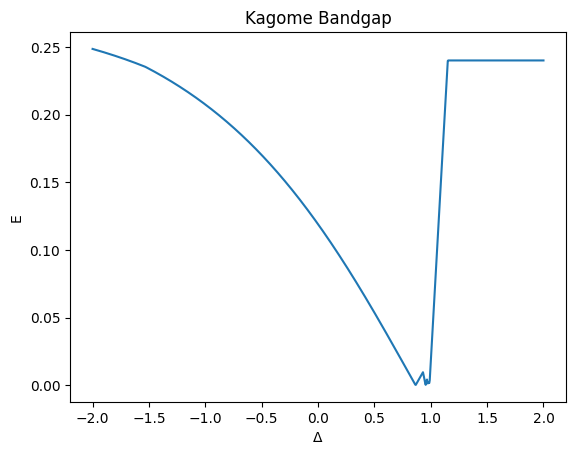

In [ ]:
pequedel_23 = -0.02

# deltas_23 = [-2, -1.7, -1.5, -1.2, -1,-0.8,-0.6,-0.4,-0.2 0,0.2,0.4,0.7, 1, 1.2,1.5,1.7 2]  # You might edit this list...
deltas_23 = np.linspace(-2, 2, 1000)
hamiltonians_23: list[SparsePauliOp] = [
    hamiltonian_kagome_22(12, delta=delta_23, pequedelta=pequedel_23) for delta_23 in deltas_23
]

numerical_bandgaps_23 = []

for hamiltonian_23 in hamiltonians_23:
    numerical_bandgaps_23.append(obtain_numerical_bandgap(hamiltonian_23))
plt.plot(deltas_23, numerical_bandgaps_23)
plt.xlabel("$\Delta$")
plt.ylabel("E")
plt.title("Kagome Bandgap")

The sharp peak in Δ = 1, shows the presence of a phase transition, however,there are no more points like this, in contrast with the linear chain, that has two non differentiable points, Δ = -1 and Δ = 1, related to the ferromagnetic and antiferromagnetic phase transitions.

### Improving the noisy device result

We did not have enough time to do a run in an actual IBM Quantum Computer, however we can still do the discussion of improving the results.

Respect to the transpile optimization, as Luciano explained, there are 4 different levels of it, using the highest (3) will obviosly lead to obtaining the best results, however, it will also mean a higher transpilation time.

The Ansatz adaptability, is already tackled in a small deegree, as we use a Hardware Efficiente Ansatz (HAE), instead of using some other approaches which use other parameters and more complex circuits as ansatz. Nevertheless, a further improvement could be done, the gates involved in the Ansatz (in our case Rz, Rx and CZ/CX), should be replaced by native gates of the circuit. Each device will have some gates that can be directly performed depend of the implementation.

Error mitigation is a tool already implement in Qiskit which allows to simulate the hardware and counteract the noise. It has 3 levels (off, medium, high), however, IBM already  warns that a high level might include bias.

Regarding the mapping to the device, the routing problem is a big point, the number of SWAP gates, which involve 2 qubit gates (very noisy), should be reduced, and in order to do so, we should include a routing algorithm in the transpilation instead of the default mapping.

## REFERENCES <a class="anchor" id="REF"></a> [[↑]](#0)

[1] Franchini, Fabio. An introduction to integrable techniques for one-dimensional quantum systems. Vol. 940. Cham: Springer International Publishing, 2017. ([url](https://arxiv.org/abs/1609.02100))

[2] Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242-246. ([url](https://arxiv.org/abs/1704.05018))